In [2]:
import pandas as pd
import numpy as np
import re
import matplotlib.pyplot as plt
import matplotlib.cm as cm
from collections import Counter
import pickle

import nltk
nltk.download('averaged_perceptron_tagger')
nltk.download('punkt')
nltk.download('stopwords')
nltk.download('words')
nltk.download('wordnet')

In [3]:
from nltk.corpus import stopwords,wordnet
from nltk.stem.wordnet import WordNetLemmatizer
from nltk.tokenize import RegexpTokenizer


In [4]:
from textblob import TextBlob
from wordcloud import WordCloud

In [5]:
import pyLDAvis
import pyLDAvis.gensim
import pyLDAvis.gensim_models as gensimvis

In [6]:
from gensim.corpora import Dictionary
from gensim.models import LdaModel,CoherenceModel

In [7]:
from gensim.models.coherencemodel import CoherenceModel
from itertools import product

In [8]:
df_pre = pd.read_json("Pre_Covid.json")
df_post = pd.read_json("Post_Covid.json")

In [9]:
print(df_pre .shape, df_post.shape)

(60603, 11) (76052, 11)


In [20]:
df_pre = df_pre[['text','created_at']]
df_post = df_post[['text','created_at']]

df_pre['created_at'] = df_pre['created_at'].apply(lambda a: pd.to_datetime(a).to_datetime64())
df_post['created_at'] = df_post['created_at'].apply(lambda a: pd.to_datetime(a).to_datetime64())

In [11]:
print(df_pre.head(5))
print(str(min(df_pre['created_at'])),str(max(df_pre['created_at'])))
print(df_post.head(5))
print(str(min(df_post['created_at'])),str(max(df_post['created_at'])))

                                                text          created_at
0  @bel_oubli You need not worry about buying, I ... 2020-03-30 22:47:24
1  @AdminLKO @myogiadityanath @CMOfficeUP @PMOInd... 2020-03-30 22:06:28
2  @Pun_Starr Dont forget tiktok for time pass un... 2020-03-30 20:35:06
3  @bigbasket_com Have you started delivery at 40... 2020-03-30 20:24:49
4  Happy to play and select for lucky draw🤞 in @a... 2020-03-30 20:20:42
2018-07-01 02:37:36 2020-03-30 22:47:24
                                                text          created_at
0  @OneTsukuyomi @Flipkart @flipkartsupport I don... 2022-09-24 22:20:51
1  @bennylis @sizzlerbuckie @wba1199 Seriously! I... 2022-09-24 22:16:37
2  @AshwiniKChoubey @PiyushGoyalOffc never ever t... 2022-09-24 21:29:45
3  @Flipkart @flipkartsupport @amazonIN \nStop ma... 2022-09-24 21:25:11
4  @PiyushGoyal @PiyushGoyalOffc dear sir, please... 2022-09-24 21:23:49
2021-01-01 02:19:18 2022-09-24 22:20:51


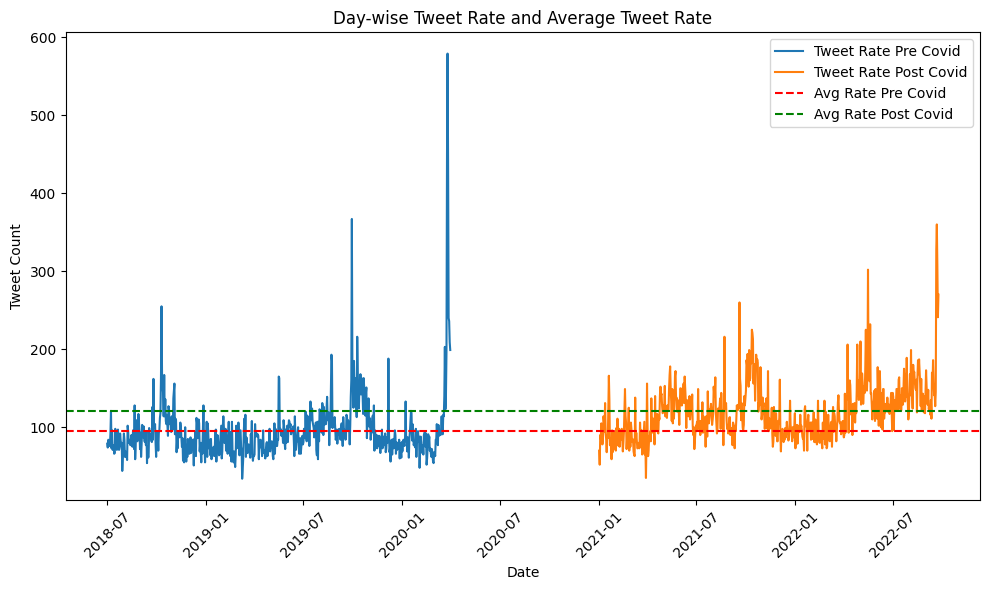

In [12]:
# Group data by date and calculate tweet counts
tweet_counts_pre_covid = df_pre.groupby(df_pre['created_at'].dt.date).size()
tweet_counts_post_covid = df_post.groupby(df_post['created_at'].dt.date).size()

# Calculate average tweet rates for the given date ranges
start_date_pre = pd.to_datetime("2018-07-01").date()
end_date_pre = pd.to_datetime("2020-03-30").date()
average_rate_pre = tweet_counts_pre_covid.loc[start_date_pre:end_date_pre].mean()

start_date_post = pd.to_datetime("2021-01-01").date()
end_date_post = pd.to_datetime("2022-09-24").date()
average_rate_post = tweet_counts_post_covid.loc[start_date_post:end_date_post].mean()

# Plotting
plt.figure(figsize=(10, 6))

# Plotting tweet rates
plt.plot(tweet_counts_pre_covid.index, tweet_counts_pre_covid.values, label='Tweet Rate Pre Covid')
plt.plot(tweet_counts_post_covid.index, tweet_counts_post_covid.values, label='Tweet Rate Post Covid')

# Plotting average tweet rates
plt.axhline(y=average_rate_pre, color='r', linestyle='--', label='Avg Rate Pre Covid')
plt.axhline(y=average_rate_post, color='g', linestyle='--', label='Avg Rate Post Covid')

plt.xlabel('Date')
plt.ylabel('Tweet Count')
plt.title('Day-wise Tweet Rate and Average Tweet Rate')
plt.legend()
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

In [13]:
def get_wordnet_pos(tag):
    # Map POS tag to WordNet POS tag
    if tag.startswith('J'):
        return 'a'  # Adjective
    elif tag.startswith('V'):
        return 'v'  # Verb
    elif tag.startswith('N'):
        return 'n'  # Noun
    elif tag.startswith('R'):
        return 'r'  # Adverb
    else:
        return 'n'  # Default to Noun

In [14]:
def remove_emojis(data):
    emoj = re.compile("["
        u"\U0001F600-\U0001F64F"  # emoticons
        u"\U0001F300-\U0001F5FF"  # symbols & pictographs
        u"\U0001F680-\U0001F6FF"  # transport & map symbols
        u"\U0001F1E0-\U0001F1FF"  # flags (iOS)
        u"\U00002500-\U00002BEF"  # chinese char
        u"\U00002702-\U000027B0"
        u"\U00002702-\U000027B0"
        u"\U000024C2-\U0001F251"
        u"\U0001f926-\U0001f937"
        u"\U00010000-\U0010ffff"
        u"\u2640-\u2642" 
        u"\u2600-\u2B55"
        u"\u200d"
        u"\u23cf"
        u"\u23e9"
        u"\u231a"
        u"\ufe0f"  # dingbats
        u"\u3030"
                      "]+", re.UNICODE)
    return re.sub(emoj, '', data)

In [15]:
# Function for preprocessing text
def preprocess(text):
    
    text = remove_emojis(text)
    # text = re.sub(r'@\w+', '', text)
    text = re.sub(r'http[s]?://\S+', '', text)
    text = re.sub(r'\$\d+(\.\d{1,2})?', '', text)
    
    text = text.lower()
    
    text = re.sub(r'[^a-zA-Z\s]', '', text)
    text = re.sub(r'\b\d+\b', '', text)
    
    tokenizer = RegexpTokenizer(r'\w+')
    tokens = tokenizer.tokenize(text)
    
    stop = set(stopwords.words('english'))
    tokens = [token for token in tokens if token not in stop and len(token) > 2]
    tokens = [token for token in tokens if not token.isdigit()]
    
    # POS tagging
    tagged_tokens = TextBlob(' '.join(tokens)).tags
    lemmatizer = WordNetLemmatizer()
    lemmatized_tokens = [lemmatizer.lemmatize(word, pos=get_wordnet_pos(tag)) for word, tag in tagged_tokens]
    
    return lemmatized_tokens

In [16]:
df_pre['tokens'] =  df_pre['text'].apply(preprocess)
df_post['tokens'] =  df_post['text'].apply(preprocess)

In [47]:
df_pre.to_csv('lemmatized_tokens_pre_covid_raw.csv', index=False)
df_post.to_csv('lemmatized_tokens_post_covid_raw.csv', index=False)

In [17]:
df_pre.head(5)

text          created_at  \
0  @bel_oubli You need not worry about buying, I ... 2020-03-30 22:47:24   
1  @AdminLKO @myogiadityanath @CMOfficeUP @PMOInd... 2020-03-30 22:06:28   
2  @Pun_Starr Dont forget tiktok for time pass un... 2020-03-30 20:35:06   
3  @bigbasket_com Have you started delivery at 40... 2020-03-30 20:24:49   
4  Happy to play and select for lucky draw🤞 in @a... 2020-03-30 20:20:42   

                                              tokens  
0          [beloubli, need, worry, buy, buy, condom]  
1  [adminlko, myogiadityanath, cmofficeup, pmoind...  
2  [punstarr, dont, forget, tiktok, time, pas, eq...  
3  [bigbasketcom, start, delivery, anushaktinagar...  
4  [happy, play, select, lucky, draw, amazon, red...

/var/folders/qz/0qg0q3jj3nv9820748j5slf40000gn/T/ipykernel_7225/4172551555.py:10: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  colormap = cm.get_cmap('viridis')
/Users/mousaha/micromamba/lib/python3.9/site-packages/wordcloud/wordcloud.py:106: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  self.colormap = plt.cm.get_cmap(colormap)
/Users/mousaha/micromamba/lib/python3.9/site-packages/wordcloud/wordcloud.py:106: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  self.colormap = plt.c

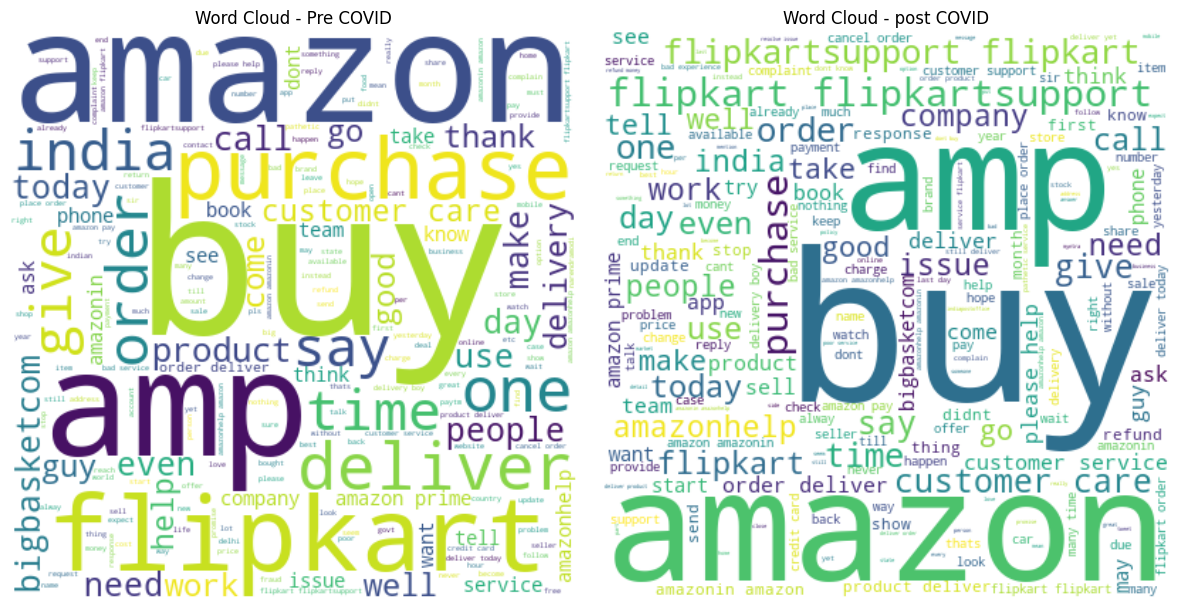

In [18]:
# Drop rows with NaN values in the 'tokens' column for both dataframes
df_pre = df_pre.dropna(subset=['tokens'])
df_post = df_post.dropna(subset=['tokens'])

# Convert tokenized words to strings and create a single string containing all words for both dataframes
all_text_pre = ' '.join(df_pre['tokens'].explode().astype(str))
all_text_post = ' '.join(df_post['tokens'].explode().astype(str))

# Specify colormap using the recommended approach
colormap = cm.get_cmap('viridis')

# Create WordCloud objects for both dataframes
wordcloud_pre = WordCloud(width=400, height=400, background_color='white', colormap=colormap).generate(all_text_pre)
wordcloud_post = WordCloud(width=400, height=400, background_color='white', colormap=colormap).generate(all_text_post)


# Create a side-by-side subplot
plt.figure(figsize=(12, 6))

# Subplot for df_pre
plt.subplot(1, 2, 1)
plt.imshow(wordcloud_pre, interpolation='bilinear')
plt.axis('off')
plt.title('Word Cloud - Pre COVID')

# Subplot for df_post
plt.subplot(1, 2, 2)
plt.imshow(wordcloud_post, interpolation='bilinear')
plt.axis('off')
plt.title('Word Cloud - post COVID')

# Adjust layout and show the plot
plt.tight_layout()
plt.show()

In [19]:
def lda_params(df):
    # Creating a dictionary to represent the documents.
    dictionary = Dictionary(df['tokens'])

    # Filtering out words that occur less than 5% of the documents, or more than 50% of the documents.
    dictionary.filter_extremes(no_below=int(0.05 * len(df)), no_above=0.5)

    corpus = [dictionary.doc2bow(doc) for doc in df['tokens']]

    temp = dictionary[0]
    id2word = dictionary.id2token

    return dictionary,corpus,id2word

In [20]:
dictionary_pre,corpus_pre,id2word_pre = lda_params(df_pre)
dictionary_post,corpus_post,id2word_post = lda_params(df_post)

In [49]:
# Saving preprocessed data
preprocessed_pre_data = {
    'dictionary_pre': dictionary_pre,
    'corpus_pre': corpus_pre,
    'id2word_pre': id2word_pre,
}

with open('preprocessed_data_pre_raw.pkl', 'wb') as f:
    pickle.dump(preprocessed_pre_data, f)

preprocessed_post_data = {
    'dictionary_post': dictionary_post,
    'corpus_post': corpus_post,
    'id2word_post': id2word_post,
}

with open('preprocessed_data_post_raw.pkl', 'wb') as f:
    pickle.dump(preprocessed_post_data, f)

In [13]:
# Loading preprocessed data
with open('preprocessed_data_pre_raw.pkl', 'rb') as f:
    loaded_data = pickle.load(f)

# Access loaded data
loaded_dictionary_pre = loaded_data['dictionary_pre']
loaded_corpus_pre = loaded_data['corpus_pre']
loaded_id2word_pre = loaded_data['id2word_pre']

# Loading preprocessed data
with open('preprocessed_data_post_raw.pkl', 'rb') as f:
    loaded_data = pickle.load(f)

# Access loaded data
loaded_dictionary_post = loaded_data['dictionary_post']
loaded_corpus_post = loaded_data['corpus_post']
loaded_id2word_post = loaded_data['id2word_post']


In [21]:
def compute_coherence_values(dictionary, corpus, texts, id2word, limit, start=2, step=1):
    coherence_c_v_values = []
    coherence_u_mass_values = []
    model_list = []
    for num_topics in range(start, limit, step):
        model = LdaModel(corpus=corpus, id2word=id2word,chunksize=1000,   \
                        alpha='auto', eta='auto', \
                        iterations=400, num_topics=num_topics, \
                        passes=20, eval_every=None)
        # model = LdaModel(corpus=corpus, num_topics=num_topics, id2word=dictionary)
        model_list.append(model)
        coherencemodel_c_v = CoherenceModel(model=model, texts=texts, dictionary=dictionary, coherence='c_v')
        coherencemodel_u_mass = CoherenceModel(model=model, texts=texts, dictionary=dictionary, coherence='u_mass')
        
        coherence_c_v = coherencemodel_c_v.get_coherence()
        coherence_u_mass = coherencemodel_u_mass.get_coherence()
        print(f"Number of Topics: {num_topics}, Coherence Score c_v: {coherence_c_v}")
        print(f"Number of Topics: {num_topics}, Coherence Score u_mass: {coherence_u_mass}")
        coherence_c_v_values.append(coherence_c_v)
        coherence_u_mass_values.append(coherence_u_mass)

    return model_list, coherence_c_v_values, coherence_u_mass_values

In [22]:
model_list_pre, coherence_c_v_values_pre, coherence_u_mass_values_pre = compute_coherence_values(dictionary=dictionary_pre, corpus=corpus_pre, texts=df_pre['tokens'], id2word=id2word_pre, start=2, limit=10)
model_list_post, coherence_c_v_values_post, coherence_u_mass_values_post = compute_coherence_values(dictionary=dictionary_post, corpus=corpus_post, texts=df_post['tokens'], id2word=id2word_post, start=2, limit=10)

Number of Topics: 2, Coherence Score c_v: 0.41507669209156217
Number of Topics: 2, Coherence Score u_mass: -2.4797913496729898
Number of Topics: 3, Coherence Score c_v: 0.4381015301768468
Number of Topics: 3, Coherence Score u_mass: -2.440714094793922
Number of Topics: 4, Coherence Score c_v: 0.3894325105908104
Number of Topics: 4, Coherence Score u_mass: -2.3911043319889824
Number of Topics: 5, Coherence Score c_v: 0.4090154152615676
Number of Topics: 5, Coherence Score u_mass: -2.2963607304647473
Number of Topics: 6, Coherence Score c_v: 0.4140436291247353
Number of Topics: 6, Coherence Score u_mass: -2.21414961114091
Number of Topics: 7, Coherence Score c_v: 0.43780578980421153
Number of Topics: 7, Coherence Score u_mass: -2.324516946891522
Number of Topics: 8, Coherence Score c_v: 0.44772034768010743
Number of Topics: 8, Coherence Score u_mass: -2.2566465029783074
Number of Topics: 9, Coherence Score c_v: 0.44159189139919275
Number of Topics: 9, Coherence Score u_mass: -2.320478959

In [23]:
def grid_search_coherence(dictionary, corpus, texts, id2word,
                          alphas, etas, chunksizes, iterations_list, passes_list, eval_every_list,
                          num_topics_list):
    best_model = None
    best_coherence = -1
    
    # Generate all combinations of hyperparameters
    hyperparameter_combinations = list(product(alphas, etas, chunksizes, iterations_list, passes_list, eval_every_list, num_topics_list))
    
    for alpha, eta, chunksize, iterations, passes, eval_every, num_topics in hyperparameter_combinations:
        print(f"Training LDA with alpha={alpha}, eta={eta}, chunksize={chunksize}, iterations={iterations}, passes={passes}, eval_every={eval_every}, num_topics={num_topics}")
        
        # Train LDA model
        model = LdaModel(corpus=corpus, id2word=id2word,
                         alpha=alpha, eta=eta,
                         chunksize=chunksize,
                         iterations=iterations,
                         num_topics=num_topics,
                         passes=passes,
                         eval_every=eval_every)
        
        # Compute Coherence Scores
        coherencemodel_c_v = CoherenceModel(model=model, texts=texts, dictionary=dictionary, coherence='c_v')
        coherencemodel_u_mass = CoherenceModel(model=model, texts=texts, dictionary=dictionary, coherence='u_mass')
        
        coherence_c_v = coherencemodel_c_v.get_coherence()
        coherence_u_mass = coherencemodel_u_mass.get_coherence()
        
        print(f"Coherence Score c_v: {coherence_c_v}, Coherence Score u_mass: {coherence_u_mass}")
        
        # Update best model if needed
        if coherence_c_v > best_coherence:
            best_model = model
            best_coherence = coherence_c_v
    
    return best_model, best_coherence

In [24]:
# Example usage:
alphas = ['auto', 0.01]
etas = ['auto', 0.01]
chunksizes = [1000, 2000]
iterations_list = [400, 500]
passes_list = [20, 30]
eval_every_list = [None, 1]
num_topics_list = [5, 6]
best_model, best_coherence = grid_search_coherence(dictionary_pre, corpus_pre, df_pre['tokens'], id2word_pre, alphas, etas, chunksizes, iterations_list, passes_list, eval_every_list, num_topics_list)


Training LDA with alpha=auto, eta=auto, chunksize=1000, iterations=400, passes=20, eval_every=None, num_topics=5
Coherence Score c_v: 0.4388496543836582, Coherence Score u_mass: -2.3653436568103188
Training LDA with alpha=auto, eta=auto, chunksize=1000, iterations=400, passes=20, eval_every=None, num_topics=6
Coherence Score c_v: 0.46142442760950925, Coherence Score u_mass: -2.265686978498909
Training LDA with alpha=auto, eta=auto, chunksize=1000, iterations=400, passes=20, eval_every=1, num_topics=5
Coherence Score c_v: 0.43145609468519835, Coherence Score u_mass: -2.19871417255625
Training LDA with alpha=auto, eta=auto, chunksize=1000, iterations=400, passes=20, eval_every=1, num_topics=6
Coherence Score c_v: 0.40118856093469796, Coherence Score u_mass: -2.285028919725303
Training LDA with alpha=auto, eta=auto, chunksize=1000, iterations=400, passes=30, eval_every=None, num_topics=5
Coherence Score c_v: 0.4240914870617282, Coherence Score u_mass: -2.286939035842781
Training LDA with 

In [26]:
best_model, best_coherence

(<gensim.models.ldamodel.LdaModel at 0x2d5b0e370>, 0.46925774208369964)

In [25]:
best_model_post, best_coherence_post = grid_search_coherence(dictionary_post, corpus_post, df_post['tokens'], id2word_post, alphas, etas, chunksizes, iterations_list, passes_list, eval_every_list, num_topics_list)

Training LDA with alpha=auto, eta=auto, chunksize=1000, iterations=400, passes=20, eval_every=None, num_topics=5
Coherence Score c_v: 0.448100172558423, Coherence Score u_mass: -2.3150496677438657
Training LDA with alpha=auto, eta=auto, chunksize=1000, iterations=400, passes=20, eval_every=None, num_topics=6
Coherence Score c_v: 0.473963401632195, Coherence Score u_mass: -2.2509042557451817
Training LDA with alpha=auto, eta=auto, chunksize=1000, iterations=400, passes=20, eval_every=1, num_topics=5
Coherence Score c_v: 0.4829158343589417, Coherence Score u_mass: -2.3018326220138277
Training LDA with alpha=auto, eta=auto, chunksize=1000, iterations=400, passes=20, eval_every=1, num_topics=6
Coherence Score c_v: 0.4771744724791131, Coherence Score u_mass: -2.2811474517637844
Training LDA with alpha=auto, eta=auto, chunksize=1000, iterations=400, passes=30, eval_every=None, num_topics=5
Coherence Score c_v: 0.4569952838650898, Coherence Score u_mass: -2.3683520611224216
Training LDA with 

In [27]:
print('Pre Covid model Perplexity:', best_model.log_perplexity(corpus_pre))
print('Post Covid model Perplexity:', best_model_post.log_perplexity(corpus_post))

Pre Covid model Perplexity: -3.3119089130590558
Post Covid model Perplexity: -3.2006708822753316


Lower values of perplexity generally indicate better generalization performance. 

Comparable Models: Since the perplexity scores are close, it suggests that both models are approximately equally good at generalizing to new, unseen documents.

Consistency Over Time: The similarity in perplexity before and after Covid suggests that the complexity or unpredictability of the topics discussed in the tweets did not change significantly due to the pandemic.

In [ ]:
best_model.save("pre_covid_best_lda_model_raw")
with open("pre_covid_best_coherence_score_raw.txt", "w") as f:
        f.write(str(best_coherence))
best_model_post.save("post_covid_best_lda_model_raw")
with open("post_covid_best_coherence_score_raw.txt", "w") as f:
        f.write(str(best_coherence_post))

In [9]:
# pre_covid_model = best_model
# post_covid_model = best_model_post

pre_covid_model = LdaModel.load("pre_covid_best_lda_model_raw")
post_covid_model = LdaModel.load("post_covid_best_lda_model_raw")


In [10]:
# Topic found in the optimal model for both pre-covid and post-covid
def show_topics(model, num_words=10):
    topics = model.show_topics(formatted=False, num_words=num_words)
    for i, topic in enumerate(topics):
        words = ", ".join([word for word, _ in topic[1]])
        print(f"Topic {i+1}: {words}")

print("Pre-COVID Topics:")
show_topics(pre_covid_model)

print("\nPost-COVID Topics:")
show_topics(post_covid_model)


Pre-COVID Topics:
Topic 1: amazon, amazonin, amazonhelp, customer, product, day, service, time, dont, like
Topic 2: purchase, bigbasketcom, like, service, get, make, please, dont, time, one
Topic 3: deliver, order, get, delivery, call, service, day, time, customer, say
Topic 4: flipkart, flipkartsupport, customer, product, service, amazonin, get, day, order, please
Topic 5: buy, amp, one, make, day, time, say, like, give, dont

Post-COVID Topics:
Topic 1: deliver, order, get, product, customer, service, day, time, delivery, one
Topic 2: purchase, please, help, one, product, also, give, get, take, receive
Topic 3: flipkart, flipkartsupport, product, receive, refund, issue, order, give, customer, service
Topic 4: buy, amp, dont, money, give, one, get, take, say, also
Topic 5: amazon, amazonin, amazonhelp, give, refund, product, time, customer, say, take


In [17]:
# Visualize the topics for the pre-COVID model
pre_covid_vis = gensimvis.prepare(pre_covid_model, loaded_corpus_pre, loaded_dictionary_pre)
pyLDAvis.display(pre_covid_vis)

# Visualize the topics for the post-COVID model
post_covid_vis = gensimvis.prepare(post_covid_model, loaded_corpus_post, loaded_dictionary_post)
pyLDAvis.display(post_covid_vis)

In [19]:
pyLDAvis.save_html(pre_covid_vis, 'pre_covid_lda.html')
pyLDAvis.save_html(post_covid_vis, 'post_covid_lda.html')


In [32]:
def get_top_words(model, num_words=5):
    top_words = {}
    topics = model.show_topics(formatted=False, num_words=num_words)
    for topic_id, topic in topics:
        words = [word for word, _ in topic]
        top_words[topic_id] = words
    return top_words


In [33]:
def plot_topic_weight(model, corpus, title, ax=None):
    if ax is None:
        fig, ax = plt.subplots()
        
    # Get topic distribution
    topic_distribution = np.zeros(model.num_topics)
    for doc in corpus:
        doc_topics = model.get_document_topics(doc)
        for topic, weight in doc_topics:
            topic_distribution[topic] += weight
    topic_distribution /= topic_distribution.sum()
    
    # Get top words for each topic
    top_words = get_top_words(model, num_words=10)
    
    # Create bar graph
    bars = ax.bar(range(1, model.num_topics + 1), topic_distribution)
    
    # Annotate with top words
    for i, bar in enumerate(bars):
        yval = bar.get_height()
        words = ", ".join(top_words[i])
        print(words)
        ax.text(bar.get_x() + bar.get_width()/2.0, yval, words, va='bottom')  # va: vertical alignment
    
    ax.set_xlabel('Topic')
    ax.set_ylabel('Proportion')
    ax.set_title(title)

amazon, amazonin, amazonhelp, customer, product, day, service, time, dont, like
purchase, bigbasketcom, like, service, get, make, please, dont, time, one
deliver, order, get, delivery, call, service, day, time, customer, say
flipkart, flipkartsupport, customer, product, service, amazonin, get, day, order, please
buy, amp, one, make, day, time, say, like, give, dont
deliver, order, get, product, customer, service, day, time, delivery, one
purchase, please, help, one, product, also, give, get, take, receive
flipkart, flipkartsupport, product, receive, refund, issue, order, give, customer, service
buy, amp, dont, money, give, one, get, take, say, also
amazon, amazonin, amazonhelp, give, refund, product, time, customer, say, take


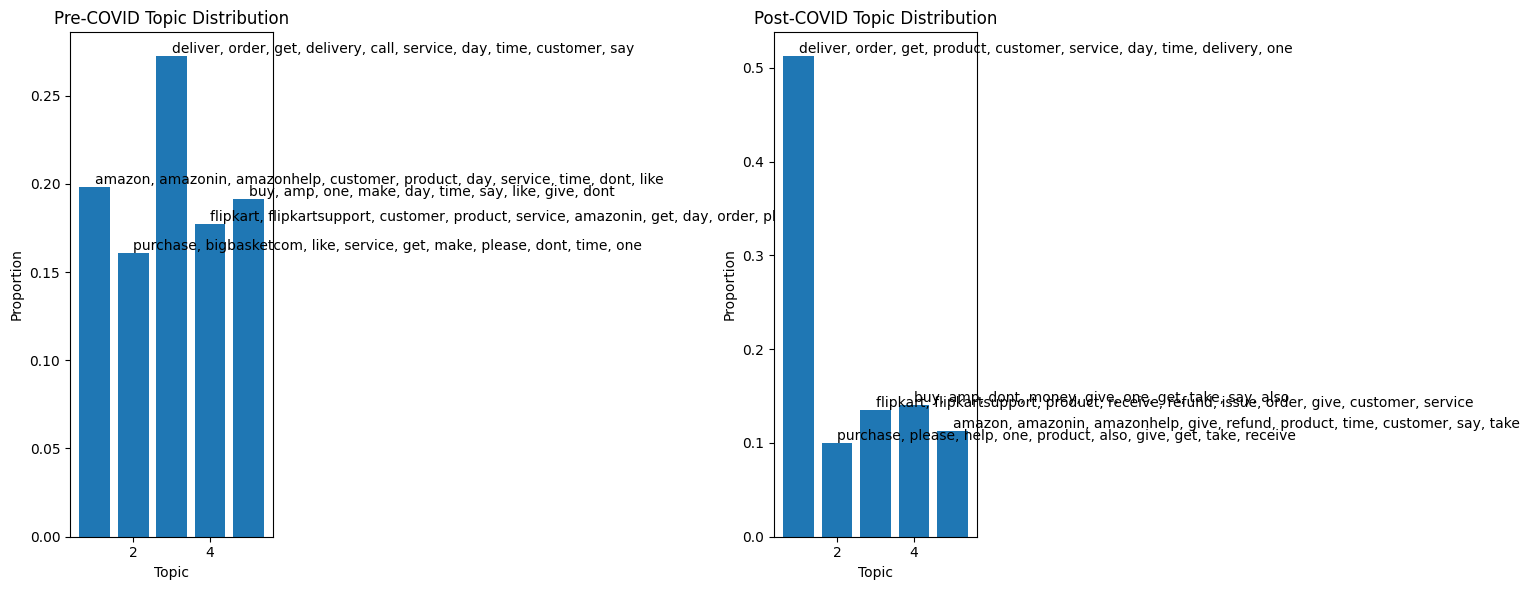

In [34]:
fig, axes = plt.subplots(1, 2, figsize=(15, 6))

# For pre-COVID model and corpus
plot_topic_weight(pre_covid_model, corpus_pre, 'Pre-COVID Topic Distribution', ax=axes[0])

# For post-COVID model and corpus
plot_topic_weight(post_covid_model, corpus_post, 'Post-COVID Topic Distribution', ax=axes[1])

plt.tight_layout()
plt.show()

In [35]:
def sentiment_by_topic(model, corpus, texts):
    topic_sentiment = {}
    for doc, text in zip(corpus, texts):
        doc_topics = model.get_document_topics(doc)
        sentiment = TextBlob(text).sentiment.polarity
        for topic, weight in doc_topics:
            if topic not in topic_sentiment:
                topic_sentiment[topic] = []
            topic_sentiment[topic].append(sentiment * weight)
    
    avg_sentiment = {topic: np.mean(sentiments) for topic, sentiments in topic_sentiment.items()}
    return avg_sentiment

In [36]:
pre_covid_texts = [' '.join(tokens) for tokens in df_pre['tokens']]
post_covid_texts = [' '.join(tokens) for tokens in df_post['tokens']]
pre_covid_sentiment = sentiment_by_topic(pre_covid_model, corpus_pre,pre_covid_texts )
post_covid_sentiment = sentiment_by_topic(post_covid_model, corpus_post, post_covid_texts)

In [37]:
print(pre_covid_sentiment)
print(post_covid_sentiment)

{4: 0.04513677771174833, 1: 0.0366177636480464, 2: 0.006867472441927399, 0: 0.05962537196612517, 3: 0.027766088604824987}
{0: 0.004939751728284903, 1: 0.0031337781953044734, 2: 0.0008511771443134015, 3: 0.004605156288768271, 4: 0.0036498621728142163}


### Pre-COVID Topics:

1. **Topic 1: Amazon-Centric Customer Experience**  
   - Words: "amazon, amazonin, amazonhelp, customer, product, day, service, time, dont, like"  
   - Sentiment Score: 0.0596 (Slightly Positive)
   
2. **Topic 2: General Purchasing Experience**
   - Words: "purchase, bigbasketcom, like, service, get, make, please, dont, time, one"  
   - Sentiment Score: 0.0366 (Slightly Positive)
   
3. **Topic 3: Delivery and Service**
   - Words: "deliver, order, get, delivery, call, service, day, time, customer, say"  
   - Sentiment Score: 0.0069 (Neutral)
   
4. **Topic 4: Flipkart Customer Interactions**
   - Words: "flipkart, flipkartsupport, customer, product, service, amazonin, get, day, order, please"  
   - Sentiment Score: 0.0278 (Neutral)
   
5. **Topic 5: Buying Behavior**
   - Words: "buy, amp, one, make, day, time, say, like, give, dont"  
   - Sentiment Score: 0.0451 (Slightly Positive)

### Post-COVID Topics:

1. **Topic 1: Delivery and Product Experience**
   - Words: "deliver, order, get, product, customer, service, day, time, delivery, one"  
   - Sentiment Score: 0.0049 (Neutral)
   
2. **Topic 2: Assistance and Product Reception**
   - Words: "purchase, please, help, one, product, also, give, get, take, receive"  
   - Sentiment Score: 0.0031 (Neutral)
   
3. **Topic 3: Flipkart Issues and Customer Service**
   - Words: "flipkart, flipkartsupport, product, receive, refund, issue, order, give, customer, service"  
   - Sentiment Score: 0.0009 (Neutral)
   
4. **Topic 4: Buying Considerations**
   - Words: "buy, amp, dont, money, give, one, get, take, say, also"  
   - Sentiment Score: 0.0046 (Neutral)
   
5. **Topic 5: Amazon Refunds and Customer Service**
   - Words: "amazon, amazonin, amazonhelp, give, refund, product, time, customer, say, take"  
   - Sentiment Score: 0.0036 (Neutral)

### Observations:

- **Sentiment Shift**: Pre-COVID topics generally have higher sentiment scores compared to post-COVID topics. This could indicate a more positive consumer perception before the pandemic.
  
- **Customer Service Focus**: Both pre and post-COVID, there is a strong focus on customer service and delivery, but with varying sentiment scores. Post-COVID topics are more neutral in sentiment, possibly indicating increased scrutiny or expectations from customers.
  
- **Platform-Specific Topics**: Both Amazon and Flipkart are often mentioned, but the topics related to them have shifted from general customer experience to more specific issues like refunds and product reception post-COVID.
  
- **Buying Behavior**: The topic related to buying behavior remains but shifts from a slightly positive sentiment pre-COVID to a neutral sentiment post-COVID.


Increased Keywords: {'onetsukuyomi': 1, 'flipkart': 14287, 'flipkartsupport': 7263, 'dont': 2168, 'know': 422, 'list': 49, 'product': 4946, 'deliver': 3351, 'properly': 191, 'wait': 711, 'sale': -149, 'book': 407, 'device': -69, 'hard': 86, 'earn': 139, 'money': 1544, 'get': 3026, 'kind': 236, 'issue': 2563, 'bennylis': 1, 'sizzlerbuckie': 1, 'wba': 1, 'seriously': 75, 'much': 212, 'understandable': -2, 'ready': 104, 'take': 1449, 'even': 965, 'bowl': -18, 'due': 533, 'away': 61, 'jerk': 4, 'pause': -6, 'well': 160, 'ashwinikchoubey': 18, 'piyushgoyaloffc': 161, 'never': 573, 'ever': 242, 'think': 190, 'pay': 1065, 'hefty': 10, 'amount': 684, 'behave': 40, 'like': 508, 'consignment': 83, 'languish': 4, 'bengaluru': 9, 'hub': 269, 'since': 912, 'last': 926, 'hour': 157, 'amp': 216, 'intentionally': 17, 'please': 3372, 'help': 2035, 'amazonin': 1598, 'stop': 374, 'make': 415, 'pool': -2, 'public': 63, 'bigbilliondays': 2, 'amazonseliya': 2, 'lie': 3, 'cheat': 577, 'piyushgoyal': 268, 'de

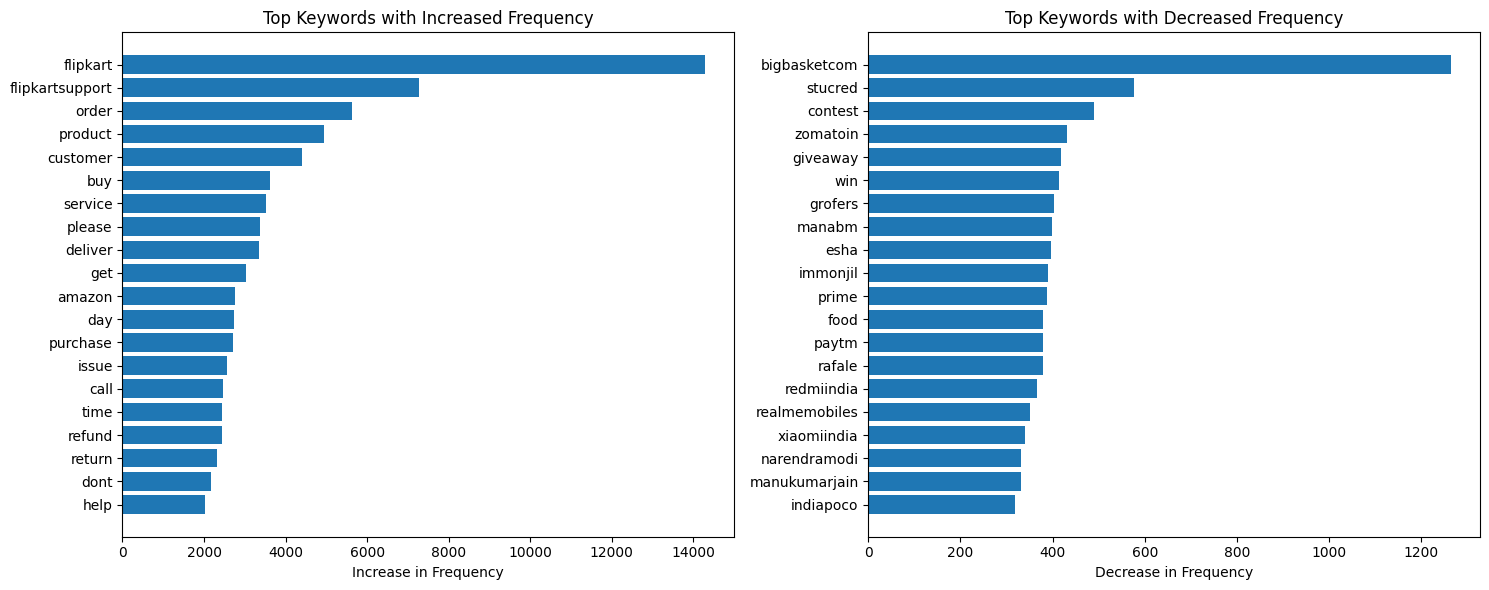

In [42]:
def keyword_analysis(texts):
    words = [word for text in texts for word in text.split()]
    return Counter(words)

pre_covid_keywords = keyword_analysis(pre_covid_texts)
post_covid_keywords = keyword_analysis(post_covid_texts)

# Find increased keywords
increased_keywords = {word: post_covid_keywords[word] - pre_covid_keywords.get(word, 0) 
                      for word in post_covid_keywords}

# Find decreased keywords
decreased_keywords = {word: pre_covid_keywords[word] - post_covid_keywords.get(word, 0) 
                      for word in pre_covid_keywords}

print("Increased Keywords:", increased_keywords)
print("Decreased Keywords:", decreased_keywords)

# Sort by frequency change and take the top 10 keywords
increased_keywords = dict(sorted(increased_keywords.items(), key=lambda x: x[1], reverse=True)[:20])
decreased_keywords = dict(sorted(decreased_keywords.items(), key=lambda x: x[1], reverse=True)[:20])

# Create subplots
fig, axes = plt.subplots(1, 2, figsize=(15, 6))

# Plot increased keywords
axes[0].barh(range(len(increased_keywords)), list(increased_keywords.values()), align='center')
axes[0].set_yticks(range(len(increased_keywords)))
axes[0].set_yticklabels(list(increased_keywords.keys()))
axes[0].invert_yaxis()
axes[0].set_xlabel('Increase in Frequency')
axes[0].set_title('Top Keywords with Increased Frequency')

# Plot decreased keywords
axes[1].barh(range(len(decreased_keywords)), list(decreased_keywords.values()), align='center')
axes[1].set_yticks(range(len(decreased_keywords)))
axes[1].set_yticklabels(list(decreased_keywords.keys()))
axes[1].invert_yaxis()
axes[1].set_xlabel('Decrease in Frequency')
axes[1].set_title('Top Keywords with Decreased Frequency')

plt.tight_layout()
plt.show()


In [13]:
df_pre = pd.DataFrame(pd.read_csv("lemmatized_tokens_pre_covid_raw.csv"))
df_post = pd.DataFrame(pd.read_csv("lemmatized_tokens_post_covid_raw.csv"))
pre_covid_model = LdaModel.load("pre_covid_best_lda_model_raw")
post_covid_model = LdaModel.load("post_covid_best_lda_model_raw")

In [14]:
# Loading preprocessed data
with open('preprocessed_data_pre_raw.pkl', 'rb') as f:
    loaded_data = pickle.load(f)

# Access loaded data
dictionary_pre = loaded_data['dictionary_pre']
corpus_pre = loaded_data['corpus_pre']
id2word_pre = loaded_data['id2word_pre']

# Loading preprocessed data
with open('preprocessed_data_post_raw.pkl', 'rb') as f:
    loaded_data = pickle.load(f)

# Access loaded data
dictionary_post = loaded_data['dictionary_post']
corpus_post = loaded_data['corpus_post']
id2word_post = loaded_data['id2word_post']

In [15]:
def assign_dominant_topic(model, corpus):
    dominant_topics = []
    for doc in corpus:
        doc_topics = model.get_document_topics(doc)
        dominant_topic = sorted(doc_topics, key=lambda x: x[1], reverse=True)[0][0]
        dominant_topics.append(dominant_topic)
    return dominant_topics

# Assuming pre_covid_corpus and post_covid_corpus are your corpus data
df_pre['dominant_topic'] = assign_dominant_topic(pre_covid_model, corpus_pre)
df_post['dominant_topic'] = assign_dominant_topic(post_covid_model, corpus_post)


In [16]:
pre_covid_topic_labels = {
    0: 'Amazon Customer Service',
    1: 'BigBasket and Service Issues',
    2: 'Delivery and Order Management',
    3: 'Flipkart Customer Experience',
    4: 'General Buying Behavior'
}

post_covid_topic_labels = {
    0: 'Delivery and Product Experience',
    1: 'Assistance and Product Reception',
    2: 'Flipkart Issues and Customer Service',
    3: 'Buying Considerations',
    4: 'Amazon Refunds and Customer Service'
}

In [24]:
def plot_topic_over_time(df, title, topic_labels):
    df_grouped = df.groupby([pd.Grouper(key='created_at', freq='M'), 'dominant_topic']).size().reset_index(name='counts')
    for topic in df_grouped['dominant_topic'].unique():
        topic_time = df_grouped[df_grouped['dominant_topic'] == topic]
        plt.plot(topic_time['created_at'], topic_time['counts'], label=f"{topic_labels.get(topic, f'Topic {topic}')}")

    plt.title(title)
    plt.xlabel('Time')
    plt.ylabel('Tweet Counts')
    plt.xticks(rotation='vertical') 
    plt.legend()
    plt.show()

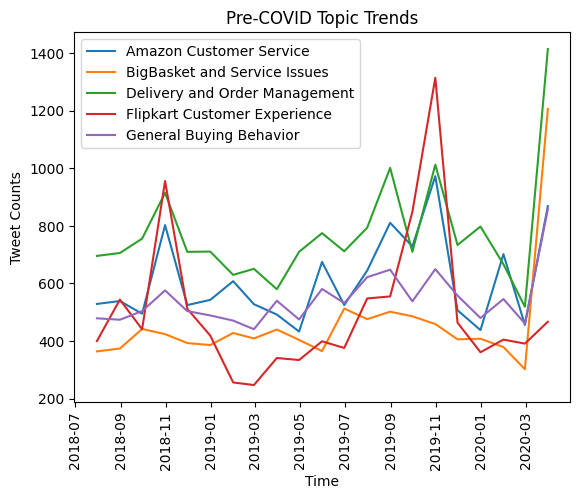

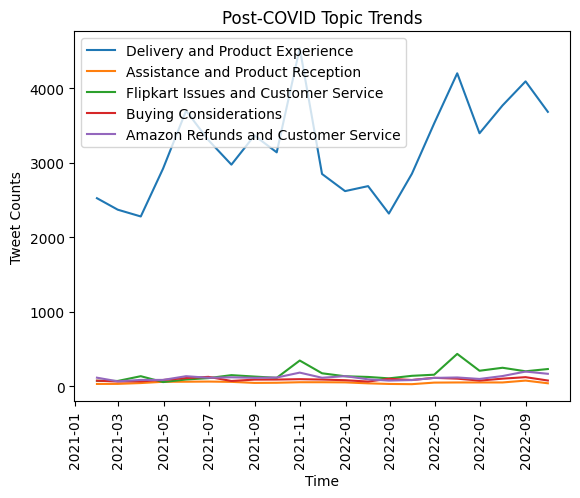

In [25]:
plot_topic_over_time(df_pre, 'Pre-COVID Topic Trends', pre_covid_topic_labels)
plot_topic_over_time(df_post, 'Post-COVID Topic Trends',post_covid_topic_labels)

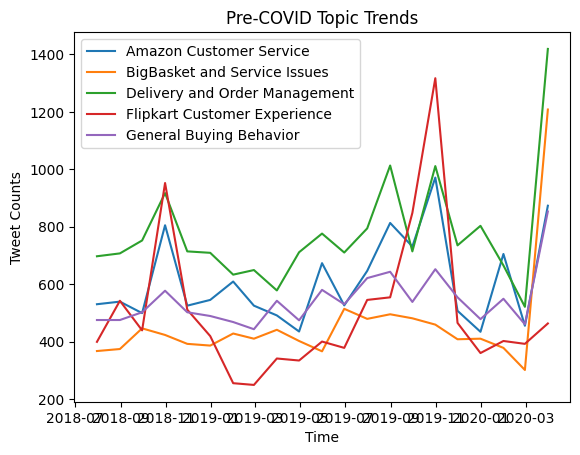

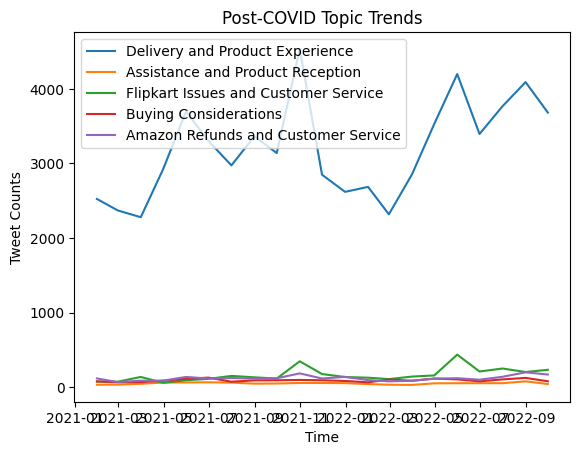

In [46]:
plot_topic_over_time(df_pre, 'Pre-COVID Topic Trends', pre_covid_topic_labels)
plot_topic_over_time(df_post, 'Post-COVID Topic Trends',post_covid_topic_labels)